In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.options.display.max_columns = 999

## First load the dataset, investigate its shape and show some first rows:

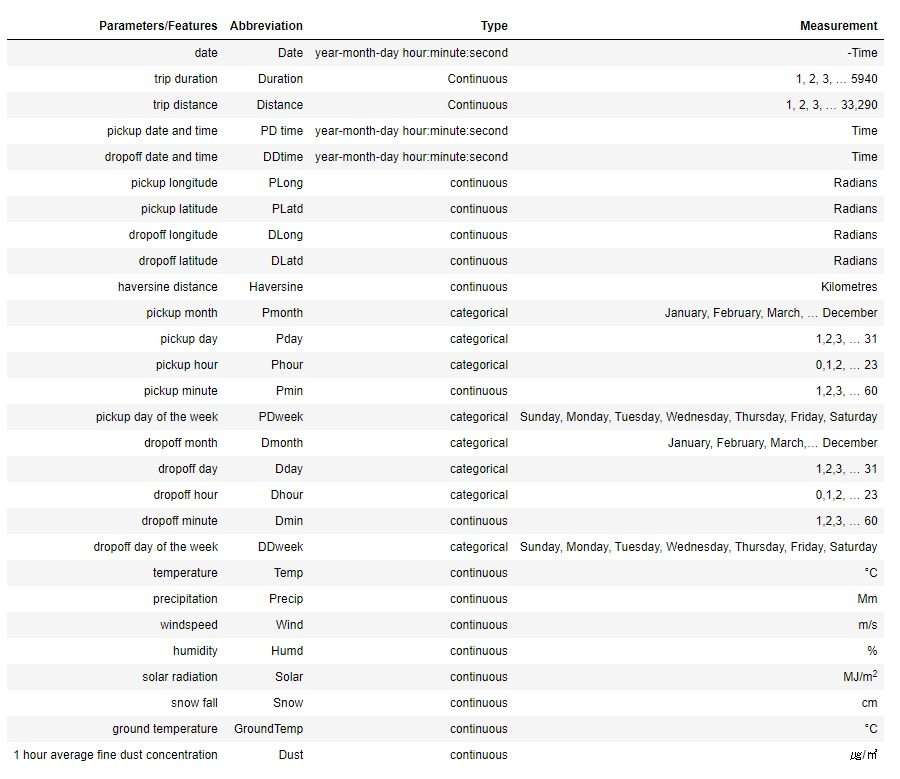

In [4]:
from IPython.display import Image
Image(filename='../data/data_dict_seoul.jpeg')

In [6]:
df = pd.read_csv('../data/dataset.csv.zip', compression='zip')

In [7]:
df.shape

(9601139, 26)

In [8]:
df.head()

,Unnamed: 0,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour,Pmin,PDweek,Dmonth,Dday,Dhour,Dmin,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
0,0,3,50,37.544666,126.888359,37.544666,126.888359,0.000000,1,1,0,0,0,1,1,0,4,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
1,1,24,7670,37.506199,127.003944,37.551250,127.035103,5.713529,1,1,0,0,0,1,1,0,25,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
2,2,8,1390,37.544590,127.057083,37.537014,127.061096,0.913702,1,1,0,0,0,1,1,0,9,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
3,3,8,1820,37.571102,127.023560,37.561447,127.034920,1.468027,1,1,0,1,0,1,1,0,10,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
4,4,4,850,37.573242,127.015907,37.565849,127.016403,0.823227,1,1,0,1,0,1,1,0,6,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0


* Define categorical or nummeric features:

In [9]:
col_types = {'Duration':'num', 'Distance':'num', 'PLong':'num', 'PLatd':'num', 'DLong':'num',
       'DLatd':'num', 'Haversine':'num', 'Pmonth':'cat', 'Pday':'cat', 'Phour':'cat', 'Pmin':'num', 'PDweek':'cat',
       'Dmonth':'cat', 'Dday':'cat', 'Dhour':'cat', 'Dmin':'num', 'DDweek':'cat', 'Temp':'num', 'Precip':'num', 'Wind':'num',
       'Humid':'num', 'Solar':'num', 'Snow':'num', 'GroundTemp':'num', 'Dust':'num'}

In [10]:
def get_column_types():
    num = {key:col_types[key] for key in col_types if col_types[key]=='num'}
    cat = {key:col_types[key] for key in col_types if col_types[key]=='cat'}
    return list(num.keys()), list(cat.keys())

num_cols, cat_cols = get_column_types()

### Exploratory data analysis
**Observations:**
* The dataset has no missing values, no imputation needed
* The dataset has both numeric and categorical features. Categorical encoding is required

**EDA TODO:**
* Investigate data distribution 
* Outlier detection and removal
* Probe for correlations

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

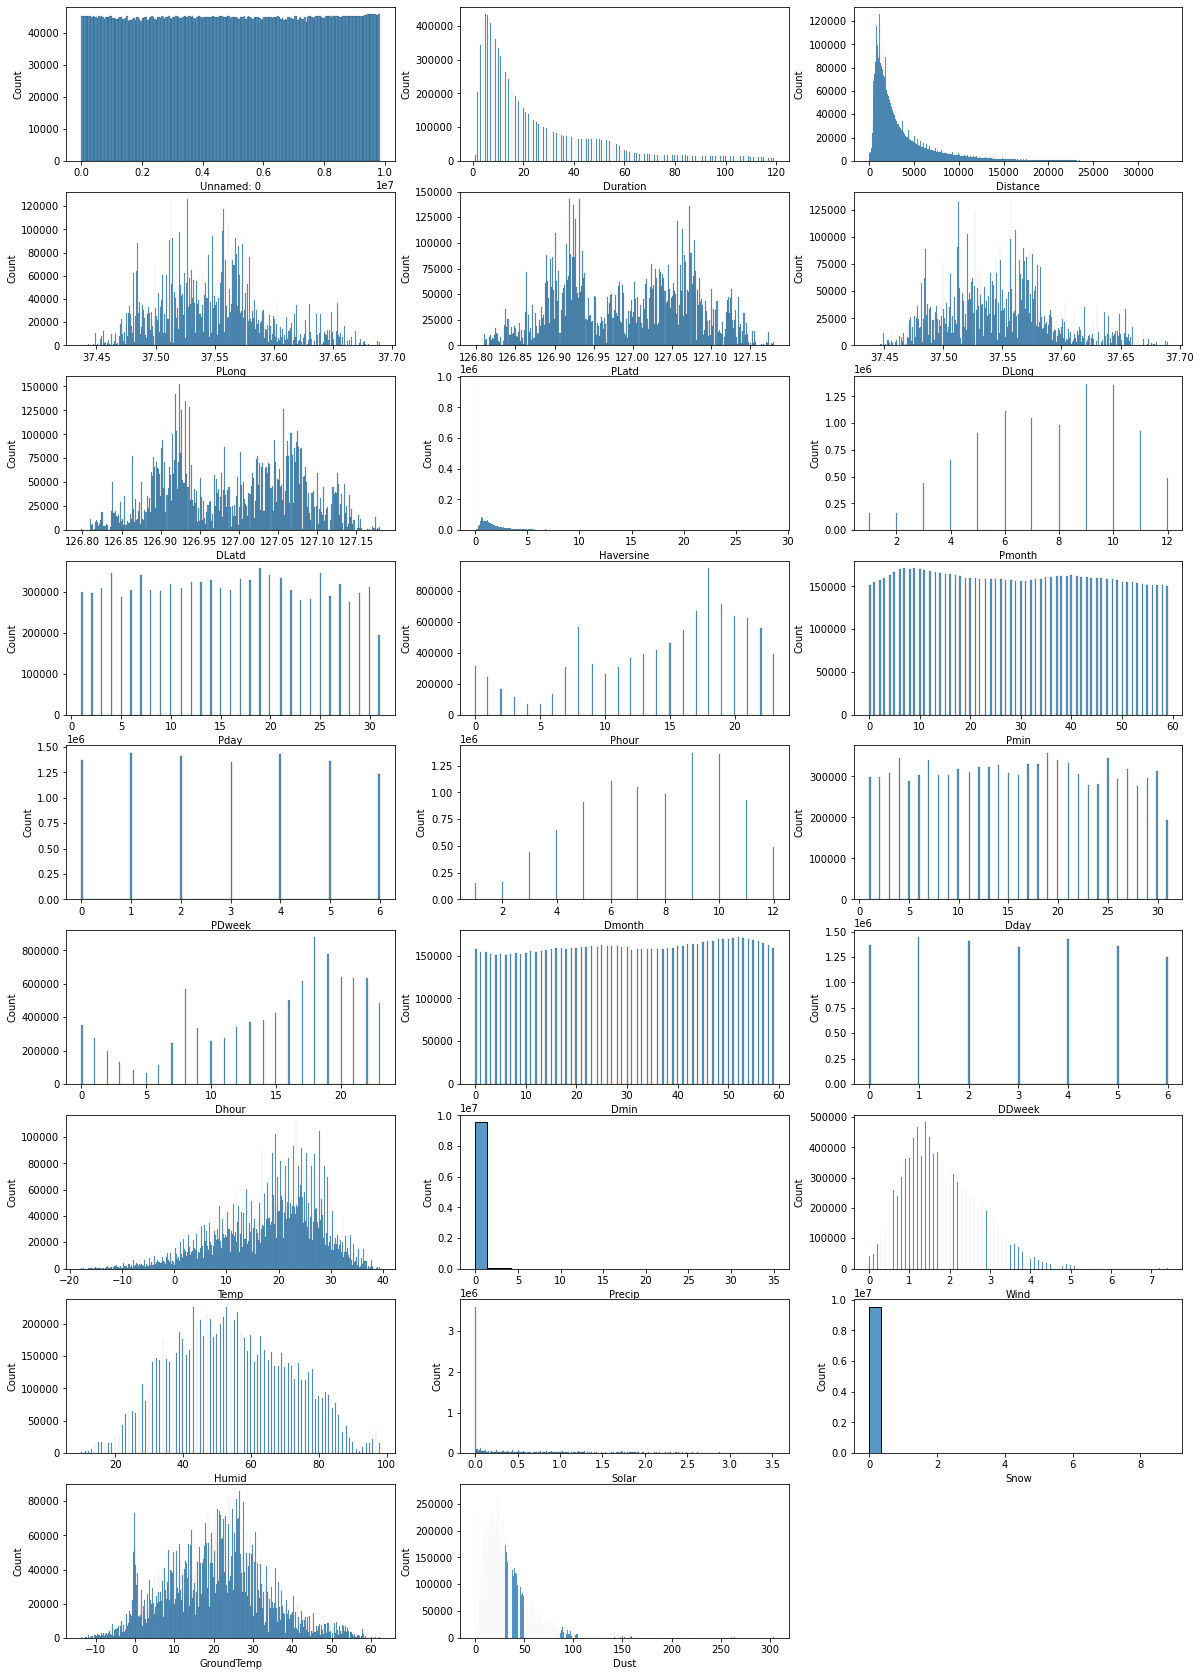

In [12]:
plt.figure(figsize=(20,30))
for i, column in enumerate(df.columns, 1):
    plt.subplot(len(df.columns)//3+1,3,i)
    sns.histplot(df[column])

Observation:
* Duration and Distance have quite similar distribution. There may be strong correlation between these features.
* Rare values or outliers may exist in Precip, Snow, Dust, Solar, Wind, Haversine as their distributions have very long tails.
* We may need to investigate weather pattern in Seoul to futher establish correlation between features.
* There are peaks in the distibutions of Hours and Months. Thus, we can think of adding binary features such as **peak_hour** and **peak_season**

* Feature Boxplot:

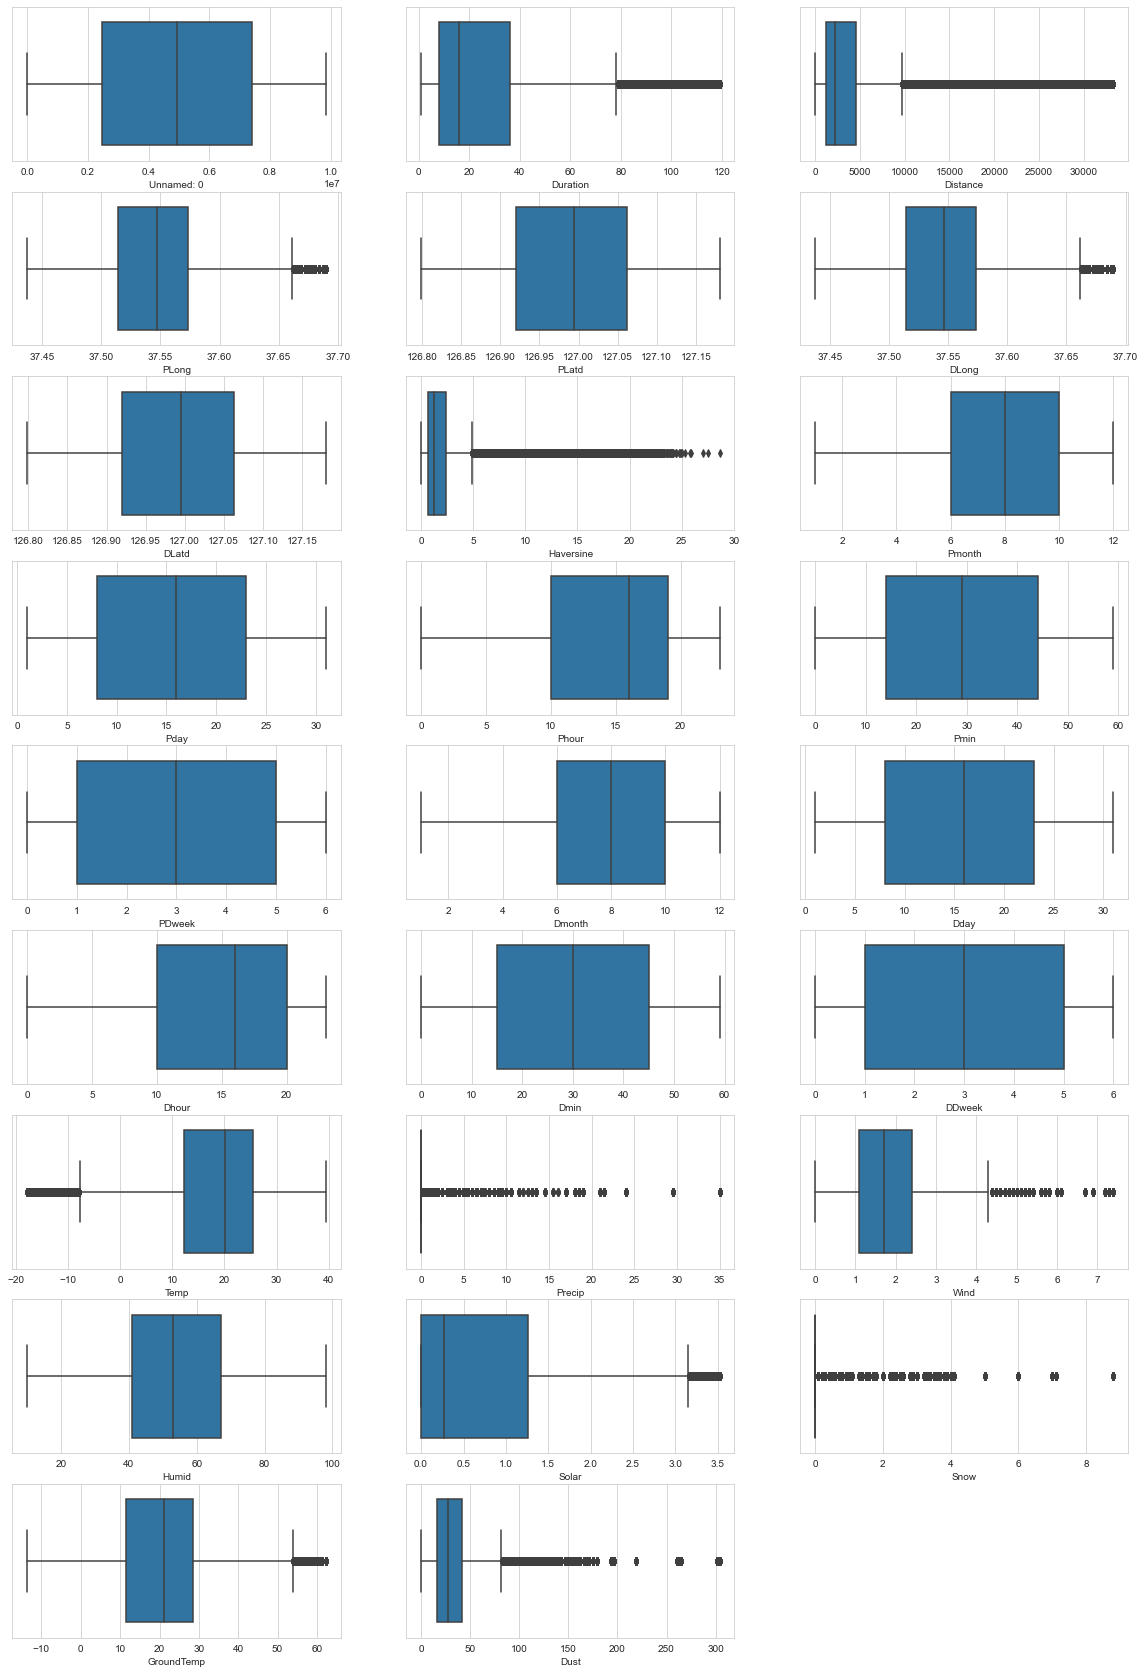

In [13]:
plt.figure(figsize=(20,30))
sns.set_style('whitegrid')
for i, column in enumerate(df.columns, 1):
    plt.subplot(len(df.columns)//3+1,3,i)
    sns.boxplot(x=df[column])

The boxplots above indciate rare values in fact exists in the following features: Precip, Wind, Snow, Dust. We will perform outlier removal on these features.

In [14]:
# I am using IQR to investiage the outliers
col_with_outliers = ['Precip', 'Wind', 'Snow', 'Dust', 'Duration', 'Distance', 'Haversine']

def get_outlier_index(df, cols, multiplier=1.5):
    results = {}
    index = []
    for col in cols:
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        lower = q1 - multiplier*(q3-q1)
        upper = q3 + multiplier*(q3-q1)
        ind = df.index[(df[col] < lower) | (df[col] > upper)] # index of outlier
        results[col] = [len(ind), len(ind)/len(df)]        
        index = list(set(index) | set(ind))
    return results, index


def remove_outliers(df, outlier_index):
    """Remove outlier"""
    return df[~df.index.isin(outlier_index)]

* Outlier removal on the whole dataset df:

In [15]:
results, outlier_index = get_outlier_index(df, col_with_outliers, multiplier=1.5)
results

{'Precip': [115901, 0.012071588589645457],
 'Wind': [132177, 0.013766804126052128],
 'Snow': [69446, 0.007233100156137725],
 'Dust': [393799, 0.04101586280544423],
 'Duration': [561121, 0.05844317012804418],
 'Distance': [760588, 0.0792185177196164],
 'Haversine': [720444, 0.07503734713141846]}

In [16]:
len(outlier_index)/len(df)

0.20487756713031652

About 20% of data will be removed as outliers.

* Remove outliers on whole dataset:

In [17]:
df1 = remove_outliers(df, outlier_index)
df1.shape

(7634081, 26)

* Drop duplicates:

In [18]:
df1 = df1.drop_duplicates()
df1.shape

(7634081, 26)

* Probe for correlation:

In [19]:
corr_mat = df1.corr()

In [20]:
corr_mat['Duration'].sort_values(ascending=False)

Duration      1.000000
Distance      0.750490
Haversine     0.277796
Dhour         0.140491
Phour         0.136094
Temp          0.113911
GroundTemp    0.104934
DDweek        0.080869
PDweek        0.080569
Wind          0.076699
Solar         0.062284
DLatd         0.013238
PLatd         0.012688
Dmin         -0.007742
Pday         -0.008320
Dday         -0.008428
Pmin         -0.010466
Dust         -0.012076
DLong        -0.024470
PLong        -0.025967
Dmonth       -0.048140
Pmonth       -0.048240
Unnamed: 0   -0.058185
Humid        -0.095032
Precip             NaN
Snow               NaN
Name: Duration, dtype: float64

<AxesSubplot:>

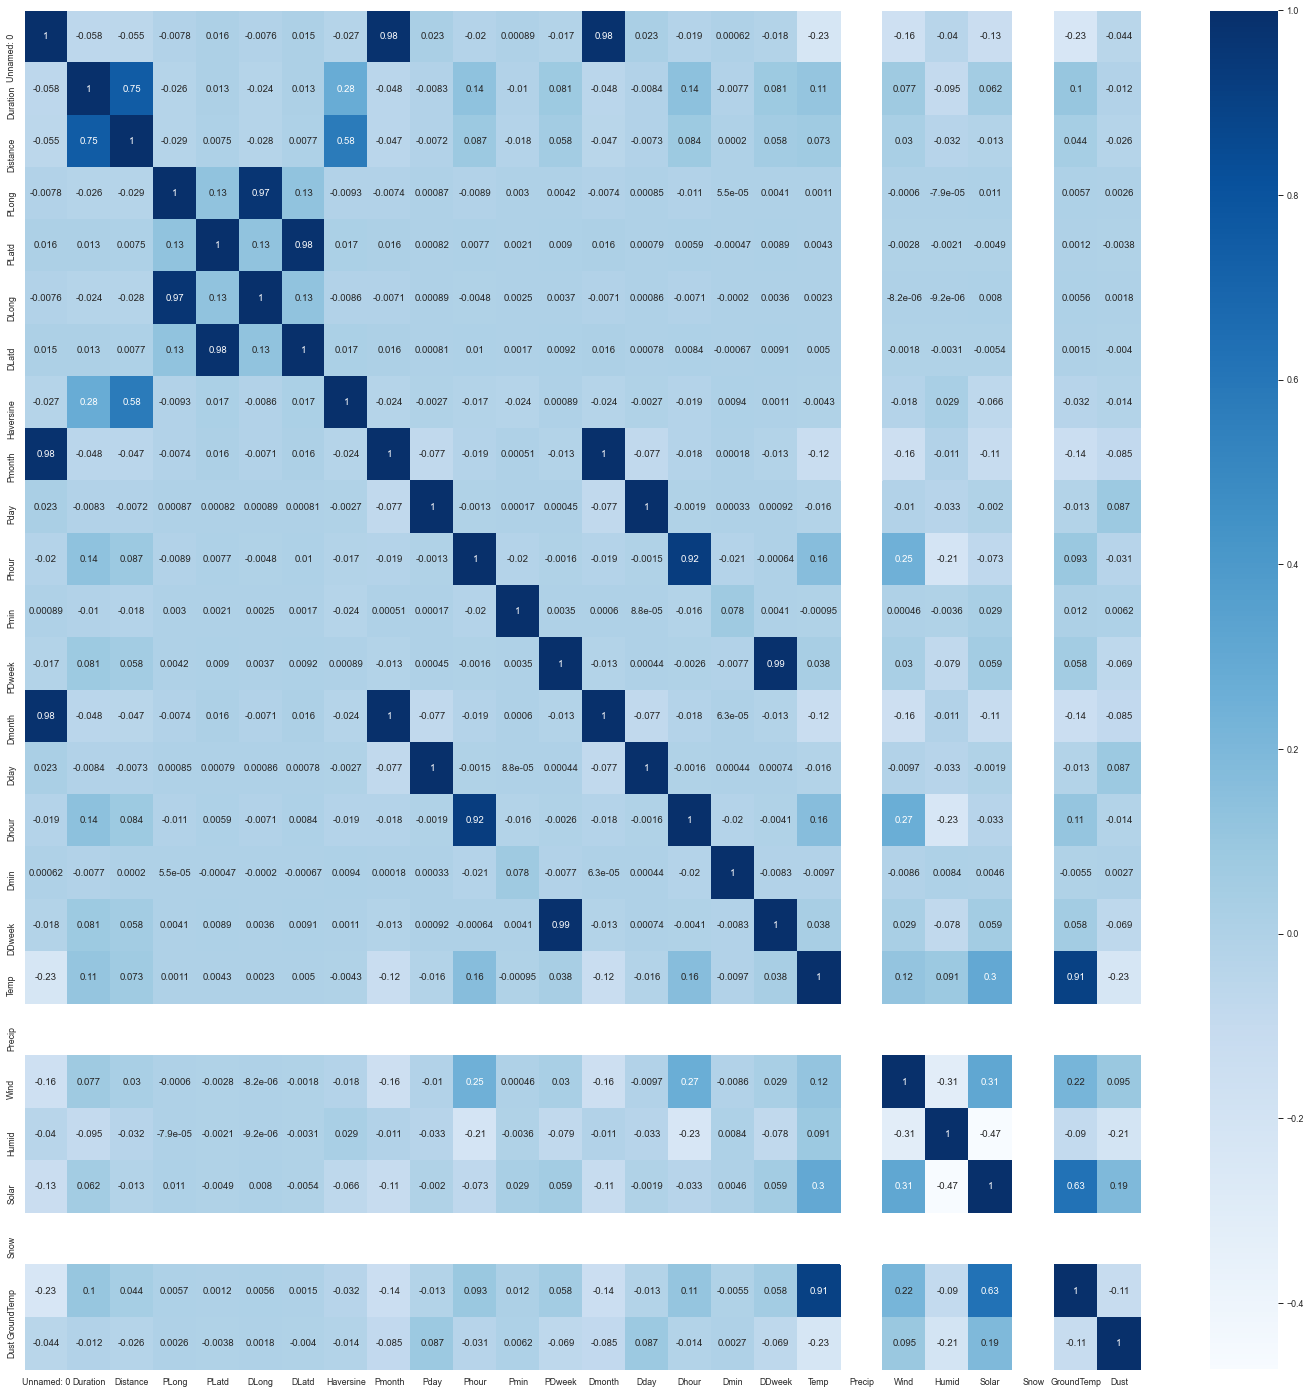

In [21]:
plt.figure(figsize=(25,25))
sns.set_context('paper', font_scale=1)
sns.heatmap(data=corr_mat, annot=True, cmap='Blues')

Observations:
* Ignore Precip and Snow for now
* Highly corelated features: Distance, Haversine, Phour, Temp, GroundTemp, Humid

### Split the dataset into train, validation and test sets. We don't want to see the val and test set during EDA.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
def train_val_test_split(df, val_size=0.1, test_size=0.1, shuffle=True, random_state=1):
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=random_state)
    train_df, val_df = train_test_split(train_val_df, test_size=test_size/0.9, shuffle=shuffle, random_state=random_state)
    return train_df, val_df, test_df

In [24]:
train_df, val_df, test_df = train_val_test_split(df1)
len(train_df), len(val_df), len(test_df)

(6107264, 763408, 763409)

### Data pipeline

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

#### Add peak_hour and peak_season columns:
* Peak hour: 7:00-9:00 or 17:00-19:00
* Peak season: June - Oct (experimental)

In [26]:
def is_peak(t, windows):
    for window in windows:
        if t >= window[0] and t<= window[1]:
            return 1
    return 0


class AddPeakAndMinutes(BaseEstimator, TransformerMixin):
    def __init__(self, peak_hours=[[7,9], [17,19]], peak_months=[[6,10]]):
        self.peak_hours = peak_hours
        self.peak_months = peak_months
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        # add peak hour indicator
        X['PeakHour'] = X['Phour'].apply(lambda x: is_peak(x, self.peak_hours))
        # add peak month indicator
        X['PeakMonth'] = X['Pmonth'].apply(lambda x: is_peak(x, self.peak_months))
        # add minutes from midnight
        X['Minutes'] = X['Phour']*60 + X['Pmin']
        return X
    
add_peak_minutes = AddPeakAndMinutes()

#### Transformers for preprocessing
* Scaler
* One Hot Encoder

In [27]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [28]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
ohe = OneHotEncoder(drop='first')

In [48]:
keep_num_cols = ['Distance', 'Haversine','Wind','Humid','Solar','GroundTemp','Dust'] + ['Minutes']
keep_cat_cols = ['Pmonth', 'Pday', 'Phour', 'PDweek'] + ['PeakHour', 'PeakMonth']

In [49]:
# Column transformer
ct = make_column_transformer(
    (scaler, keep_num_cols),
    (ohe, keep_cat_cols),
    remainder='drop'
)

In [50]:
data_pipe = make_pipeline(add_peak_minutes, ct)

## Model training

* Prepare dataframes for training, validation and testing

In [151]:
# Separate features from target variable
X_train = train_df.drop(['Duration'], axis=1)
y_train = train_df['Duration']
X_val = val_df.drop(['Duration'], axis=1)
y_val = val_df['Duration']
X_test = test_df.drop(['Duration'], axis=1)
y_test = test_df['Duration']

# Transform features
data_pipe.fit(X_train)
X_train = data_pipe.transform(X_train)
X_val = data_pipe.transform(X_val)
X_test = data_pipe.transform(X_test)

In [152]:
X_train.shape, X_val.shape, X_test.shape

((6107264, 80), (763408, 80), (763409, 80))

### Sampling from X_train, y_train:

In [53]:
def sample_training_data(X, y, n):
    if not isinstance(y, np.ndarray):
        y = y.to_numpy()    
    index = np.random.choice(X.shape[0], n, replace=False)    
    return X[index], y[index]

### Baseline model: Linear Regression

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [55]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# Train score
train_rmse = np.sqrt(mean_squared_error(y_train, linreg.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, linreg.predict(X_test)))
train_rmse, test_rmse

(9.765609553728758, 9.799218484624417)

### Support Vector Regressor

In [37]:
from sklearn.svm import SVR

In [ ]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1, cache_size=1000)
svr_rbf.fit(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(y_train, svr_rbf.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, svr_rbf.predict(X_test)))
train_rmse, test_rmse

### Random Forests

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=5, n_jobs=16)
X_train_small, y_train_small = sample_training_data(X_train, y_train, 1000000)
rfr.fit(X_train_small, y_train_small)
train_rmse = np.sqrt(mean_squared_error(y_train_small, rfr.predict(X_train_small)))
test_rmse = np.sqrt(mean_squared_error(y_test, rfr.predict(X_test)))
train_rmse, test_rmse

### XGBoost

In [56]:
import xgboost as xgb

In [57]:
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.9, 
    learning_rate = 0.3, 
    max_depth=10, 
    alpha = 10, 
    n_estimators=40)

In [58]:
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [59]:
train_rmse = np.sqrt(mean_squared_error(y_train, xg_reg.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, xg_reg.predict(X_test)))
train_rmse, test_rmse

(8.673142665912998, 8.80802394368122)

* XGBoost looks very promising for this problem.

In [60]:
from joblib import dump
dump(xg_reg, '../src/xgb_V1.joblib')

['../src/xgb_V1.joblib']

In [149]:
dump(data_pipe, '../src/preprocess.joblib')

['../src/preprocess.joblib']

In [122]:
# print input dataframe colunms:
print(list(train_df.drop(['Duration'], axis=1).columns))
len(list(train_df.drop(['Duration'], axis=1).columns))

['Unnamed: 0', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine', 'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour', 'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow', 'GroundTemp', 'Dust']


25

In [88]:
data_pipe

Pipeline(steps=[('addpeakandminutes', AddPeakAndMinutes()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Distance', 'Haversine',
                                                   'Wind', 'Humid', 'Solar',
                                                   'GroundTemp', 'Dust',
                                                   'Minutes']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Pmonth', 'Pday', 'Phour',
                                                   'PDweek', 'PeakHour',
                                                   'PeakMonth'])]))])

In [119]:
data_pipe.steps[0][1]

AddPeakAndMinutes()

In [133]:
import numpy as np

In [144]:
input_df = pd.DataFrame(data=[
{'Unnamed: 0': np.nan,
 'Distance': 2330.0,
 'PLong': 37.595299,
 'PLatd': 127.080032,
 'DLong': 37.614738,
 'DLatd': 127.076363,
 'Haversine': 2.185552555981476,
 'Pmonth': 7.0,
 'Pday': 14.0,
 'Phour': 23.0,
 'Pmin': 38.0,
 'PDweek': 5.0,
 'Dmonth': 7.0,
 'Dday': 14.0,
 'Dhour': 23.0,
 'Dmin': 52.0,
 'DDweek': 5.0,
 'Temp': 26.6,
 'Precip': 0.0,
 'Wind': 2.0,
 'Humid': 80.0,
 'Solar': 0.0,
 'Snow': 0.0,
 'GroundTemp': 25.2,
 'Dust': 21.0}
])

In [145]:
data_pipe.transform(input_df)

<1x80 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [147]:
from joblib import load
pipe = load('../src/preprocess.joblib')

In [148]:
pipe.transform(input_df)

<1x80 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [150]:
dump(data_pipe, 'pipe.joblib')

['pipe.joblib']

In [155]:
dump(data_pipe.transform, 'pipe.pkl')

['pipe.pkl']